# Sentimental Analysis of Movie Reviews

### by Karma Tsering
My goal is to group these reviews using unsupervised learning models.

### Motivation of this project
There are too many movies and too many people with opnion on them. Its doubtful that any one would want to read these reviews, certly not companies that need to do it therefore cluster to get the jest of what is going on.

### Data Source
This dataset contains movie reviews along with their associated binary sentiment polarity labels. It is intended to serve as a benchmark for sentiment classification. 

The core dataset contains 50,000 reviews split evenly into 25k train and 25k test sets. The overall distribution of labels is balanced (25k pos and 25k neg). 

In the entire collection, no more than 30 reviews are allowed for any given movie because reviews for the same movie tend to have correlated ratings. In the labeled train/test sets, a negative review has a score <= 4 out of 10, and a positive review has a score >= 7 out of 10. Thus reviews with more neutral ratings are not included in the train/test sets.

In [8]:
import numpy as np
import pandas as pd
from os import listdir
%matplotlib inline

import spacy
nlp = spacy.load('en')

import scipy
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from os.path import isfile, join

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
#saves list of files names to loop though
neg_train_file_names = [f for f in listdir('aclImdb\\train\\neg') if isfile(join('aclImdb\\train\\neg', f))]
pos_train_file_names = [f for f in listdir('aclImdb\\train\\pos') if isfile(join('aclImdb\\train\\pos', f))]

In [8]:
#The reviews are saved in each individual files, so I looped through each file and saved the content of the files as 
#and assigned a sentement based on which folder the file was in (neg = 0/ pos = 1).
review_df1 = []
review_df2 = []

for file in neg_train_file_names:
    file1_open = open("aclImdb\\train\\neg\\{}".format(file), encoding="utf8")
    file1_content = file1_open.read()
    review_df1.append([file1_content, 0])
    
for file in pos_train_file_names:
    file1_open = open("aclImdb\\train\\pos\\{}".format(file), encoding="utf8")
    file1_content = file1_open.read()
    review_df2.append([file1_content, 1])

In [9]:
#Put them in DataFrame format
review_df1 = pd.DataFrame(review_df1)
review_df2 = pd.DataFrame(review_df2)

In [10]:
#put all the above dataframe in one dataframe
review_df = pd.concat([review_df1, review_df2]).sample(frac=1).reset_index(drop=True)
review_df.columns = ['Review', 'Rating']
print(review_df.shape)
review_df.head(10)

(25000, 2)


,Review,Rating
0,This was quite possibly the worst movie I have...,0
1,I guess this would be a great movie for a true...,0
2,"""They All Laughed"" is one of those little movi...",1
3,"I'm not a huge Freddy Krueger fan,but that doe...",0
4,To me this was Colin Farrells best movie evr! ...,1
5,Several features of this film immediately date...,1
6,"In 2004, I liked it. Then it became very stupi...",0
7,I saw this important intense film tonight. Its...,1
8,What a poor image of Professional Police Offic...,0
9,Pearl S.Buck was a brilliant author that was a...,1


### Data Frame created above

# text file for making BOW
Put all the reviews in one string in perperation for extrating key words to be used as feature later on for creating vector.

### Pick 2000 words and make BOW

In [11]:
#I cleanded the text as much as possible so to reduce load for nlp processing and to increase the number of vocas for feature
from nltk.corpus import stopwords
stopWords = stopwords.words('english')
allwords = " "
list_of_review = []
Review = []
pattern = "[-*:&$%'\\?\"/<>()\d]"
pattern2 = r"\bbr\b"
pattern3 = r'\bA\b'
pattern4 = r'--'
#pattern5 = '.+;$'

for review in review_df['Review'][0:15000]:
    #cleaning up each review text by removing above patters
    mov_review = re.sub(pattern, "", review)
    mov_review = re.sub(pattern2, "", mov_review)
    mov_review = re.sub(pattern3, "", mov_review)
    mov_review = re.sub(pattern4, "", mov_review)
    #mov_review = re.sub(pattern5, "", mov_review)
    mov_review = mov_review.split()
    mov_review = [x for x in mov_review
                if not x == ' '
                and not x == 'movie'
                and not x == '-PRON-'
                and not x == 'film'
                and not x == '\x96']

    Onefull_review = ''
    for review_words in mov_review:
        Onefull_review = Onefull_review + ' ' + review_words
    list_of_review.append(Onefull_review)

list_of_review = pd.DataFrame(list_of_review)
list_of_review.columns = ['Review']
list_of_review['Rating'] = review_df['Rating'][0:15000]
list_of_review.to_csv("list_of_review.csv")

In [23]:
list_of_review = pd.read_csv('list_of_review.csv', encoding="ISO-8859-1").drop('Unnamed: 0', 1)
print(list_of_review.shape)
list_of_review = list_of_review[0:5000]
list_of_review.head()

(15000, 2)


,Review,Rating
0,This was quite possibly the worst I have ever...,0
1,I guess this would be a great for a true beli...,0
2,They All Laughed is one of those little movie...,1
3,"Im not a huge Freddy Krueger fan,but that doe...",0
4,To me this was Colin Farrells best evr! He in...,1


<center> <h2>Vectorization of DF using Inverse Document Frequency and Term-frequency weights (tfidf) and create a vector space model.</h1> </center>
<br>
<br>
Vector space model is the representation of our documents as vectors identifiers, and these vectors are calculated according to following equation.
<br>

$$\textrm{Term frequency}= TF(t,d) = \frac{\textrm{number of times term(t) appears in document(d)}}{\textrm{total number ofterms in document(d)}}$$
<br>
<br>

$$\textrm{Inverse Documment Frequency}= IDF(t,D) = \frac{\textrm{total number of documents(D)}}{\textrm{number of documents with the term(t) in it}}$$

<br>
<br>

$$TFIDF(t,d,D) = TF(t,d)\cdot IDF(t,D)$$
<br>
<br>
This vector space model could be used for documents query, document classification, and document clustering. For the purpose of this project, I will apply some of the unsupervised models and assigned them to a group: K-Mean, minibatchkmeans, spectral clustering, MeanShift, and affinity propagation. For this vector space model there are two clusters based on the sentemental assignment but as mentioned in the data souce section these sentemental ranged from 0 to 10. Any sentement less than 4 were assigned 0 and any thing above 7 were assigned 1, so these unsupervied models could come up with more than two groups.
<br>
<br>
KMean works by randomly placing centroids in the vector space. The k parameter determines the number of centroids, that forms the clusters, assigned by you. It does two itteration, first it assignes each document to a centroid, based on their euclidean distance, using the vectors and takes an average to find a new centroids. The model repets these two itterations until no point changes cluster membership. I tried clusters of 2 to 4 and the results are below with the code.
<br>
<br>
KMean suffers form sensitivity to outliers, does not work well for non-circular cluster shapes. However it is great for pre-clustering, by creating disjointed groups in vector space for more nuanced algorethems to work on. It is the simplest and inexpensive model to apply.

<center><h4>KMean model with K=2</h4></center>
<table class="tg">
  <tr>
    <th class="tg-0pky">Rating/Cluster</th>
    <th class="tg-0pky">0</th>
    <th class="tg-0pky">1</th>
  </tr>
  <tr>
    <td class="tg-0pky">0</td>
    <td class="tg-0pky">2351</td>
    <td class="tg-0pky">3610</td>
  </tr>
  <tr>
    <td class="tg-0pky">1</td>
    <td class="tg-0pky">2180</td>
    <td class="tg-0pky">859</td>
  </tr>
</table>
<br>
<br>
Mini batch KMean is a variation of the KMean. It does essentially the same exact computation except on small batch of sample data points to improve on the computational requrement.

Spectral clustering groups togather based on similarity, a.k.a affinity, employing algorithem such as KNN and radial basis function.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

#vectorize only 5,000 rows of the review because my computer can't handle more
#split the orighal df into train and test sets for comparison leater
X_train, X_test, y_train, y_test = train_test_split(list_of_review['Review'], list_of_review['Rating'], test_size=0.25, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#inverse document frequencies
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies. Prevents divide-by-zero errors
                            )


#Applying the vectorizer to 5,000 row
list_of_review_tfidf = vectorizer.fit_transform(list_of_review['Review'])
print("Number of features: %d" % list_of_review_tfidf.get_shape()[1])

#splitting into training and test sets of thos vetorized data
#X_train_tfidf, X_test_tfidf= train_test_split(list_of_review_tfidf, test_size=0.25, random_state=0)


#Reshapes the vectorizer output into something people can read
#X_train_tfidf_csr = X_train_tfidf.tocsr()


Number of features: 21815


##### For graphing purpose

In [24]:
#singular Value Decomposition (SVD), reduce the feature space from 23051 to 10000.
#this takes long time to run
svd= TruncatedSVD(4000)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_lsa = lsa.fit_transform(list_of_review_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 95.68512398851978


In [25]:
X_train_lsa, X_test_lsa, y_train, y_test = train_test_split(X_lsa, list_of_review['Rating'], test_size=0.25, random_state=0)

In [46]:
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
Review
 I made the big mistake of actually watching this whole a few nights ago. God Im still trying to recover. This does not even deserve a . average. IMDb needs to have vote ratings possible for movies that really deserve it like this one. . is TOO HIGH. I had heard how awful this was, but I really did not think a could actually be that bad, especially in this day and era. I figured all of the cheesy god awful movies were only from the s and s. My god was I wrong. Trust me folks, this REALLY IS THAT BAD. It is beyond horrible; it is beyond pathetic; it is beyond any type of word that I can think of for it. BATTLEFIELD EARTH looks like Best Picture of the Year compared to this movie. SNAKE ISLAND which up until now was the worst Id ever seen looks like it deserves a few Oscars compared to this pathetic effort. I seriously can not believe that the makers of this thought this was a legitimate serious effort of producing a Hollywood movie. This has no business being called 

Name: 0, dtype: float64
Component 1:
Review
 Me and a friend rented this because it sounded really good. But we were wrong. First of the acting....wow...the acting was the worst, the effects were really bad as well, it seemed like a a college kid made. The plot was pretty good, but itd been done. The thing that ruined the movies the most were the actors. The main guy was the worst actor ever...its a shame Im even calling him an actor...The only good thing about this was it was so bad it was funny...so if you want a good laugh see it....but other than that...stay far away from this one. I usually love B list movies and such, but this one... I do not know how it was passed to even be put on video...this one is the worst Ive seen..and Ive seen some bad ones.                                                                                                                                                                                                                                           

Name: 1, dtype: float64
Component 2:
Review
 I thought this was hysterical. I have watched it many times and recommend it highly. Mel Brooks, was excellent. The cast was fantastic..I dont understand how this gets a out of rating. I loved it.. I have seen other movies of his and they were also funny but this one really stick out in my mind because of the humor.. His I just cant say enough about this movie. I look for it to be on periodically but it never on enough for me. The people playing the homeless people were by comparison up to the funniest standards also. Please put this on more often. I cant see it enough..Leslie Ann Warren also was another favorite of mine, ever since Cinderella. I always thought that she wasnt really funny but loved her acting. In this she was very funny..and her and Mel did a great job together. They should put more of his movies on TV.                                                                                                                            

Name: 2, dtype: float64
Component 3:
Review
 This is one of the best movies Ive ever seen. It has very good acting by Hanks, Newman, and everyone else. Definitely Jude Laws best performance. The cinematography is excellent, the editing is about as good, and includes a great original score that really fits in with the mood of the movie. The production design is also a factor in what makes this special. To me, it takes a lot to beat Godfather, but the fantastic cinematography displayed wins this contest. Definitely a Best Picture nominee in my book.                                                                                                                                                                                                                                                                                                                                                                                                                                                               

Name: 3, dtype: float64
Component 4:
Review
 What i like about you is one of those series you need to see but arent sure you would see, the beginning is cool and its sucks you into the series just for fun, the second part i season which are more stale, they come and go in what you want. what happens with many series is that they dont end with something special because the second part of the series always goes down into the drain, this one also somewhat did, the third part is the one to spoil and ruin the whole series, usually, but it doesnt, this ending is perfect for the series, it fits perfect, actually i was pretty angry about all these guys in Vals life, actually i wanted to end with Jeff in the end, but later on it changed, they chose to take Vic into the series after almost seasons without him, and that was the biggest surprise and also what made the series go on top. see it many times the series is actually very cool just dont expect the second part to be that good it isnt but t

Name: 4, dtype: float64


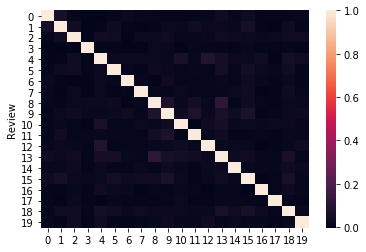

Key:
0  You can survive Surviving Christmas. I thought the television version was a bit edited way down. I like Ben Afleck. He plays Drew Johnson, a familyless adult, who is willing to pay complete strangers. The Valcos starring James Gandolfini and Catherine OHara as the parents and Christina Applegate as Lisa Valco, the daughter. Drew is lonely around the holidays because he doesnt have a family of his own so he rents out a family in the Chicago suburbs for a quarter million dollars. Bill Macy who I best remember for playing Maudes husband Arthur is hired to play Duda, the grandfather. When the whole situation comes crashing down, the truth can be painful. The Valcos household is crumbling apart from the Drew situation. Drews rich girlfriend and her parents make a surprising visit. You cant buy what you wish for! The acting and writing is mediocre but the first rate cast pulls it through to the final scene.
1  Someones at the Door. OHHH, How I miss this show so bad.. but we are lucky

7  I watched part one two days ago and today I saw part two. Of course the two parts are worlds apart so I am a little shaken by all that I just saw. I felt consumed by the knowledge of the inevitability of Ches death; for me, it clouded the entire movie. I suppose that is exactly what Soderbergh wanted us to feel, the slowly evolving inevitability of his death. Part Two was so downbeat compared to, again an inevitability but in Cuba it was positive and in Bolivia it was so negative. The politics of the movement in Bolivia were only alluded to but rarely confronted didactically. For me the memorable scenes were all at the end of the the confrontation with the jailer and the milder talk with the Bolivian official where that official questions Che about the failure of the peasants to support his revolution. I had not considered the national differences playing as much role as they did in the conflict, Argentine versus Bolivian. I thought Soderbergh dealt admirably with the inevitable pro

13  In theory, films should be a form of entertainment. While this excludes documentaries and other experimental forms of filmmaking; most movies, specially genre films, must not only tell its story or message, they must entertain their target audience in some way. All this just to say that in my opinion a bad is not a with low production values or lowbudget, a bad is one that is boring. Hellborn or Asylum of the Damned as is known in the U.S., is a bad simply because it is just not involving, and irremediably boring and tiresome. While it has a very good premise, it is just poorly developed and the mediocre acting doesnt make things better. On another hands the probably could had been a fine or even classic Bmovie, but here it is just a bad attempt at filmmaking. Director Philip J. Jones tells the tale of James Bishop Matt Stasi, a young psychiatry resident, who just got his dream job at St. Andrew Mental Hospital; but the old asylum seems to hide a secret. After the mysterious death 

18  I cant understand at all why so many Godzilla fans think this is excellent, one of the best Godzilla films ever in fact. This is horrible and one of the very few Gojira films I cant stand to watch again the other being G. vs Megalon. The plot is too campy to be in the Heisei series, a series that attempted to turn the aging Godzilla franchise into bonafide action films, revolving around ideas that seemed more in place in than . It just sounded ridiculous, especially with some of the subject matter, take for example the WW scene, with the Japanese soldiers praising a dying Godzillasaurus, a mournful and serious tone, take the exuberant former commander turn capitalist and his death, serious seens in a its fans somehow denote as played for laughs, as a goofy romp with guilty illogical fun, if so than this is easily one of the most tasteless films Ive seen, however I think its more likely it was only talent the filmmakers lacked and this was a case of a straight faced action gone bad.

In [49]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:20,0:20]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(20))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(20):
    print(i,sim_matrix.index[i])

# K-Mean
##### 2 clusters

Adjusted Rand Index
0.09057858272793927
Silhouette coefficient:
0.001468568013961343
Comparing k-means traning clusters against the data:
Rating    0     1
row_0            
0       920  1485
1       955   390
             precision    recall  f1-score   support

          0       0.49      0.38      0.43      2405
          1       0.21      0.29      0.24      1345

avg / total       0.39      0.35      0.36      3750



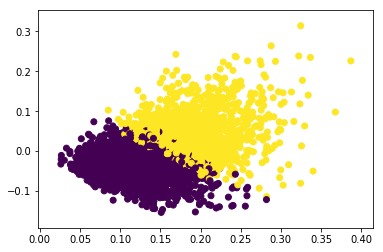

In [26]:
from sklearn.cluster import KMeans
KMean = KMeans(n_clusters=2, random_state=42, n_jobs=-1)
KMean.fit(X_train_lsa)

y_KMean2 = KMean.predict(X_train_lsa)

labels = KMean.labels_
print("Adjusted Rand Index")
print(metrics.adjusted_rand_score(y_KMean2, y_train))
# Check the solution against the data.
print('Silhouette coefficient:')
print(metrics.silhouette_score(X_train_lsa, labels, metric='euclidean'))

# Check the solution against the data.
print('Comparing k-means traning clusters against the data:')
print(pd.crosstab(y_KMean2, y_train))
print(classification_report(y_KMean2, y_train))

# Plot the solution.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=y_KMean2)
plt.show()

##### 3 clulster

In [27]:
from sklearn.cluster import KMeans
KMean = KMeans(n_clusters=3, random_state=42, n_jobs=-1)
KMean.fit(X_train_lsa)
labels = KMean.labels_

# Check the solution against the data.
print('Silhouette coefficient:')
print(metrics.silhouette_score(X_train_lsa, labels, metric='euclidean'))

Silhouette coefficient:
-0.00038633398671641456


##### 4 clulster

In [28]:
from sklearn.cluster import KMeans
KMean = KMeans(n_clusters=4, random_state=42)
KMean.fit(X_train_lsa)

labels = KMean.labels_

# Check the solution against the data.
print('Silhouette coefficient:')
print(metrics.silhouette_score(X_train_lsa, labels, metric='euclidean'))

Silhouette coefficient:
0.0007014065063959163


In [29]:
from sklearn.cluster import KMeans
KMean = KMeans(n_clusters=8, random_state=42)
KMean.fit(X_train_lsa)

labels = KMean.labels_

# Check the solution against the data.
print('Silhouette coefficient:')
print(metrics.silhouette_score(X_train_lsa, labels, metric='euclidean'))

Silhouette coefficient:
0.0005586626112842102


### minibatchkmeans
##### 2 clusters

Adjusted Rand Index
0.08271273752304611
Silhouette coefficient:
0.0017156825098014832
Comparing k-means clusters against the data:
Rating    0     1
row_0            
0       887  1427
1       988   448
             precision    recall  f1-score   support

          0       0.47      0.38      0.42      2314
          1       0.24      0.31      0.27      1436

avg / total       0.38      0.36      0.36      3750



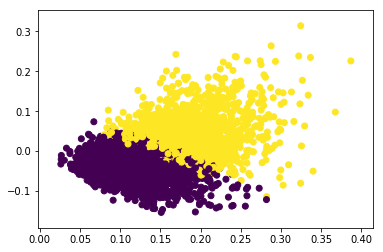

In [30]:
from sklearn.cluster import MiniBatchKMeans
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=200)
minibatchkmeans.fit(X_train_lsa)

# Add the new predicted cluster memberships to the data frame.
predict_mini2 = minibatchkmeans.predict(X_train_lsa)

labels = minibatchkmeans.labels_

print("Adjusted Rand Index")
print(metrics.adjusted_rand_score(predict_mini2, y_train))

# Check the solution against the data.
print('Silhouette coefficient:')
print(metrics.silhouette_score(X_train_lsa, labels, metric='euclidean'))

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(predict_mini2, y_train))
print(classification_report(predict_mini2, y_train))

# Plot the solution.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=predict_mini2)
plt.show()

##### 3 clusters

In [9]:
from sklearn.cluster import MiniBatchKMeans
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=3,
    batch_size=200)
minibatchkmeans.fit(X_train_lsa)

labels = minibatchkmeans.labels_

# Check the solution against the data.
print('Silhouette coefficient:')
print(metrics.silhouette_score(X_train_lsa, labels, metric='euclidean'))

Silhouette coefficient:
-0.0009317466255784837


##### 4 clusters

In [10]:
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=4,
    batch_size=200)
minibatchkmeans.fit(X_train_lsa)

labels = minibatchkmeans.labels_

# Check the solution against the data.
print('Silhouette coefficient:')
print(metrics.silhouette_score(X_train_lsa, labels, metric='euclidean'))

Silhouette coefficient:
0.00012833061922858777


# SpectralClustering
#### 2 clusters

C:\Users\ktser\Anaconda3\lib\site-packages\scipy\sparse\csgraph\_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


Adjusted Rand Index
0.07670331221433617
Silhouette coefficient:
0.0009887438890998383
Comparing the assigned categories to the ones in the data:
Rating     0     1
row_0             
0        840   320
1       1035  1555
             precision    recall  f1-score   support

          0       0.45      0.72      0.55      1160
          1       0.83      0.60      0.70      2590

avg / total       0.71      0.64      0.65      3750



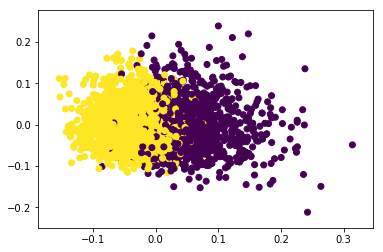

In [31]:
from sklearn.cluster import SpectralClustering

# Declare and fit the model.
sc = SpectralClustering(n_clusters=2)
sc.fit(X_train_lsa)

labels = sc.labels_

#Predicted clusters.
pred_spectral2 =sc.fit_predict(X_train_lsa)

print("Adjusted Rand Index")
print(metrics.adjusted_rand_score(pred_spectral2, y_train))

# Check the solution against the data.
print('Silhouette coefficient:')
print(metrics.silhouette_score(X_train_lsa, labels, metric='euclidean'))

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(pred_spectral2, y_train))
print(classification_report(pred_spectral2, y_train))

#Graph results.
plt.scatter(X_train_lsa[:, 1], X_train_lsa[:, 2], c=pred_spectral2)
plt.show()

#### 3 clusters

In [32]:
from sklearn.cluster import SpectralClustering

# Declare and fit the model.
sc = SpectralClustering(n_clusters=3)
sc.fit(X_train_lsa)

labels = sc.labels_

# Check the solution against the data.
print('Silhouette coefficient:')
print(metrics.silhouette_score(X_train_lsa, labels, metric='euclidean'))

C:\Users\ktser\Anaconda3\lib\site-packages\scipy\sparse\csgraph\_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


Silhouette coefficient:
-0.00034848178542135907


#### 4 clusters

In [33]:
from sklearn.cluster import SpectralClustering

# Declare and fit the model.
sc = SpectralClustering(n_clusters=4)
sc.fit(X_train_lsa)

labels = sc.labels_

# Check the solution against the data.
print('Silhouette coefficient:')
print(metrics.silhouette_score(X_train_lsa, labels, metric='euclidean'))

C:\Users\ktser\Anaconda3\lib\site-packages\scipy\sparse\csgraph\_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


Silhouette coefficient:
-0.00039154432445666826


# BoW with Logistic Regression

In [107]:
#First trying some classicication models starting with logistic regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
train = lr.fit(X_train_tfidf, y_KMean)

print(X_train_tfidf.shape, y_train.shape)
print('Training set score:', lr.score(X_train_tfidf, y_KMean))

y_pred = lr.predict(X_train_tfidf)
pd.crosstab(y_KMean, y_pred)

(9000, 38735) (9000,)
Training set score: 0.9686666666666667


col_0,0,1,2
row_0,,,
0,5220,0,0
1,109,1257,28
2,145,0,2241


# GradientBoosting

In [98]:
from sklearn import ensemble

clf = ensemble.GradientBoostingClassifier()
clf.fit(X_train_tfidf, predict_mini)

y_pred = clf.predict(X_train_tfidf)


# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, predict_mini))

Comparing k-means clusters against the data:
col_0     0     1
row_0            
0      3082   138
1       463  5317


In [99]:
print('Training set score:', clf.score(X_train_tfidf, predict_mini))

Training set score: 0.9332222222222222


from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], X_train_lsa[:, 2], c=y_KMean, zdir='x')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


# MeanShift
##### Too much for my computer handel so won't be using these models

In [41]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train_lsa, quantile=0.8, n_samples=50,  n_jobs=-1)
print(bandwidth)
# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train_lsa)

y_MShift = ms.predict(X_train_lsa)
# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_MShift,  y_train))

1.407713190203311
Number of estimated clusters: 1
Comparing k-means clusters against the data:
Rating     0     1
row_0             
0       1875  1875


# AffinityPropagation

In [45]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
af = AffinityPropagation().fit(X_train_lsa)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

Done
Estimated number of clusters: 566


In [43]:
labels = af.labels_

# Check the solution against the data.
print('Silhouette coefficient:')
print(metrics.silhouette_score(X_train_lsa, labels, metric='euclidean'))

Silhouette coefficient:
0.024865309310166162
